# Abstract Prettifier

The Abstract Prettifier is a model which can help the user read the medical abstracts easier and in a well written form. It is a Natural Language Processing (NLP) Model.
We usually see a medical study will begin with a large abstract, which tells us about the introduction to results achieved in the paper. This model can make that abstract easier for the user to read by differentiating the different parts of abstracts such as Objective, Methods, Conclusions, etc. 

The paper we are replicating is here - https://arxiv.org/abs/1710.06071

The model architecture which was used to achieve the best results is here - https://arxiv.org/abs/1612.05251

## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fa7c9a4f-f3d9-1ff2-a05f-b0de2a46bb75)


## Get data

Since we are replicating the above paper, we will the use the dataset they have used for building the model.

We can get the data on github at - https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


We will use the 20k dataset for this project

In [3]:
# Check what files are in PubMed20k dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [4]:
# Starting our expirementing using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all filenames in data directory
import os
filenames = [data_dir + filenames for filenames in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to preprocess it

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads a text filename, and returns the lines of that text file as a list
  Args:
   filename: A string containing the target file path
  Returns:
   A list of strings with one string per line from the filename
  """
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
# Let's read in training lines
train_lines = get_lines(data_dir + "train.txt") 
train_lines[:25]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
# Check the total number of lines
len(train_lines)

210040

How I think our data should be represented as

```
[{"line_number" : 0,
  "target" : "BACKGROUND",
  "text" : "Emotional eating is associated with overeating and the development of obesity .\n",
  "total_lines" : 11,
  ........}]

```

Let's write a function which turns each of our dataset into the above format

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns the list of dictionaries of abstract line data.
  Takes a filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence, how many sentences
  are there in the current abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all the lines from the file
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith("###"): # check to see if the line is and ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check if its a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get the label for the text
        line_data["text"] = target_text_split[1].lower() # get target text and lower the string
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract, starting from 0 so -1
        abstract_samples.append(line_data) # add line data to the abstract samples list
    else: # If the above conditions aren't fulfilled, the lines contain a labeled sentence
      abstract_lines += line # this means all the lines between the id line and the new line belongs to the same abstract

  return abstract_samples

In [11]:
# Get data from the file and preprocesss it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
# Get validation and test samples
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [13]:
# Check length of each sample
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

Now that our data is in the form of dictionary, let's convert it into a pandas DataFrame to visualize it better

In [15]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [16]:
# Check distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

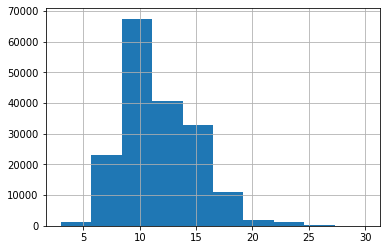

In [17]:
# Lets check length of different lines
train_df.total_lines.hist()

### Get lists of sentences

Convert abstract text lines to lists

In [18]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

# Check length of each
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
# View the first 20 training sentences
train_sentences[:20]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make Numeric Labels

We will make our labels with sklearn's Label Encoder

In [20]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [21]:
# Check out the labels
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Getting helper functions

In [23]:
!wget https://raw.githubusercontent.com/Kunal719/helper_functions/main/helper_functions.py

--2021-11-15 10:13:02--  https://raw.githubusercontent.com/Kunal719/helper_functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14751 (14K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  14.41K  --.-KB/s    in 0s      

2021-11-15 10:13:02 (28.3 MB/s) - ‘helper_functions.py’ saved [14751/14751]



In [24]:
from helper_functions import calculate_results, create_tensorboard_callback, plot_loss_curves

## Create character level data for our train, val, and test sentences

In [25]:
# Make function to split the characteres
def split_chars(text):
  return " ".join(list(text))

In [26]:
# Split sentences for each dataset
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

## Create engineered features for our model

In [27]:
# Check how many total different line numbers are there
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

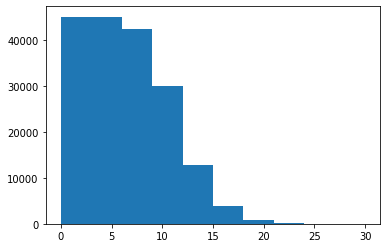

In [29]:
# Check the distribution of line number column
import matplotlib.pyplot as plt
plt.hist(train_df.line_number);

Since we can see from the above graph, most of our samples are covered in 15 lines, so we will use 15 as the depth for our engineered feature number 1

In [32]:
# Create one hot encoded tensors of our line numbers
import tensorflow as tf
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(),depth=15)
train_line_numbers_one_hot[:20], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [33]:
# Do same with val data and test data
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

In [34]:
# Check how many total different total lines are there?
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

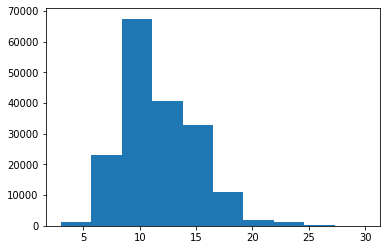

In [36]:
# Check distribution
plt.hist(train_df.total_lines);

Since most of our abstracts are of 20 lines, we will use it as depth in our engineered feature number 2

In [37]:
# One hot total line numbers
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(),depth=20)

train_total_lines_one_hot[:20], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

**Note** : Any engineered feature used to train a model must be available for testing too. In our case line numbers and total lines are available.

## Using Bert Model for our problem

In [38]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 4.2 MB/s 


In [39]:
import tensorflow_text as text
import tensorflow_hub as hub

In [40]:
preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
                                     trainable=False)
bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2',
                            trainable=False)

## Create model for our problem

In [42]:
from tensorflow.keras import layers

In [43]:
# Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string)
bert_input_tokens = preprocessing_layer(token_inputs)
bert_embedding_tokens = bert_layer(bert_input_tokens)
output_tokens = layers.Dense(64, activation="relu")(bert_embedding_tokens["pooled_output"])
token_model = tf.keras.Model(token_inputs,output_tokens)

# Character inputs
char_inputs = layers.Input(shape=[], dtype=tf.string)
bert_input_chars = preprocessing_layer(char_inputs)
bert_embedding_chars = bert_layer(bert_input_chars)
output_chars = layers.Dense(64, activation="relu")(bert_embedding_chars["pooled_output"])
char_model = tf.keras.Model(char_inputs,output_chars)

# 3. Line number model
line_num_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="lin_num_inputs")
line_num_outputs = layers.Dense(32, activation="relu")(line_num_inputs)
line_num_model = tf.keras.Model(line_num_inputs,line_num_outputs)

# 4 Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs)

# Concatenate the token and char outputs
combined_embeddings = layers.Concatenate(name="hybrid_embeddings")([token_model.output,char_model.output])

# Concatenate the combined embeddings and line_num_total output
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")([line_num_model.output,total_lines_model.output,combined_embeddings])

# Adding a dense layer to dropout random weights
dropout = layers.Dropout(0.5)(tribrid_embeddings)
x = layers.Dense(128, activation="relu")(dropout)
output_layer = layers.Dense(5, activation="softmax")(x)

# Completing the model
model = tf.keras.Model(inputs = [line_num_model.input,total_lines_model.input,token_model.input, char_model.input],
                       outputs = output_layer)

In [44]:
# Get model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]',                
                                (None, 128),                      'input_2[0][0]']                
                                 'input_word_ids':                                                
                                (None, 128),                                                

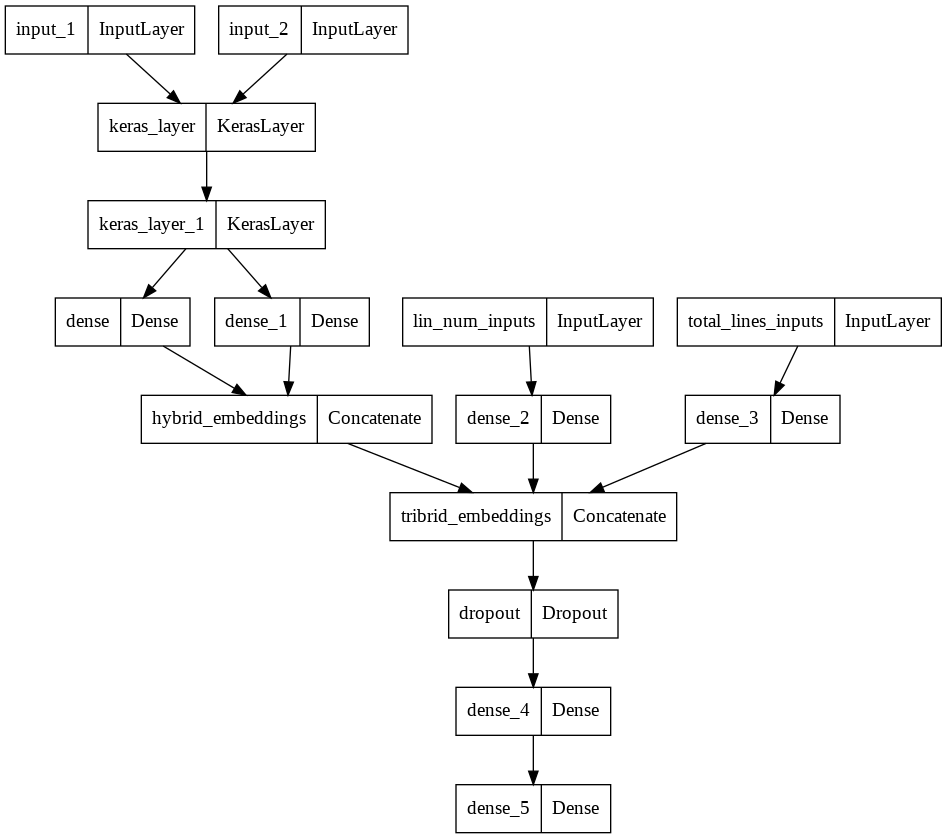

In [46]:
# Plot the model visually
from keras.utils.vis_utils import plot_model
plot_model(model)

In [47]:
# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [48]:
# Make training dataset
train_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                 train_total_lines_one_hot,
                                                 train_sentences,
                                                 train_chars))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)

train_dataset = tf.data.Dataset.zip((train_data,train_labels))

# Make validation dataset
val_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                               val_total_lines_one_hot,
                                               val_sentences,
                                               val_chars))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)

val_dataset = tf.data.Dataset.zip((val_data,val_labels))

# Applying prefetching and batching
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [49]:
# Create an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2)

In [50]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [51]:
# ModelCheckpoint Callback
checkpoint_path = "model_checkpoint/model.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [53]:
# Fit the model on full data
history_model = model.fit(train_dataset,
                          epochs=5,
                          steps_per_epoch=len(train_dataset),
                          validation_data=val_dataset,
                          validation_steps=int(0.1 * len(val_dataset)),
                          callbacks=[create_tensorboard_callback("logs_directory","model"), early_stopping, model_checkpoint,reduce_lr])

Saving TensorBoard log files to: logs_directory/model/20211115-103309
Epoch 1/5
5627/5627 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.8484
Epoch 00001: val_loss improved from inf to 0.33163, saving model to model_checkpoint/model.ckpt
5627/5627 [==============================] - 2276s 403ms/step - loss: 0.4160 - accuracy: 0.8484 - val_loss: 0.3316 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 2/5
5627/5627 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8746
Epoch 00002: val_loss improved from 0.33163 to 0.29510, saving model to model_checkpoint/model.ckpt
5627/5627 [==============================] - 2270s 403ms/step - loss: 0.3452 - accuracy: 0.8746 - val_loss: 0.2951 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 3/5
5627/5627 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.8807
Epoch 00003: val_loss improved from 0.29510 to 0.29109, saving model to model_checkpoint/model.ckpt
5627/5627 [==============================

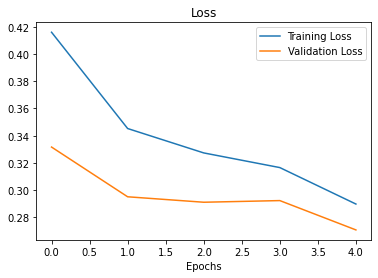

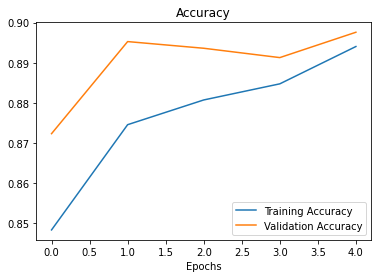

In [54]:
# Plot Loss curves
plot_loss_curves(history_model)

In [55]:
# Load best weights
model.load_weights(checkpoint_path)

In [56]:
# Evaluate on full validation set
model.evaluate(val_dataset)

945/945 [==============================] - 374s 396ms/step - loss: 0.2604 - accuracy: 0.9028


[0.2603793144226074, 0.9027869701385498]

In [57]:
# Make testing dataset
test_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                 test_total_lines_one_hot,
                                                 test_sentences,
                                                 test_chars))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_encoded)

test_dataset = tf.data.Dataset.zip((test_data,test_labels))

# Applying prefetching and batching
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
# Evaluate on full test dataset
model.evaluate(test_dataset)

942/942 [==============================] - 372s 395ms/step - loss: 0.2758 - accuracy: 0.8995


[0.27575328946113586, 0.8994524478912354]

In [59]:
# Make predictions on the test dataset
model_pred_probs = model.predict(test_dataset)
model_pred_probs[:10]

array([[3.9851558e-01, 3.0273510e-04, 1.6404435e-02, 5.8398205e-01,
        7.9520489e-04],
       [6.1577924e-02, 6.5098278e-04, 8.2790178e-01, 7.1899466e-02,
        3.7969906e-02],
       [3.3961281e-03, 1.0939186e-04, 9.4809186e-01, 4.2170798e-03,
        4.4185575e-02],
       [2.2675553e-03, 2.6559324e-03, 1.1632537e-01, 9.2859840e-04,
        8.7782252e-01],
       [8.3969484e-05, 5.3349552e-03, 8.6212112e-03, 1.8028461e-05,
        9.8594183e-01],
       [5.4047864e-06, 9.7657843e-03, 1.7651236e-03, 1.2600087e-06,
        9.8846239e-01],
       [3.4264551e-06, 1.2163499e-02, 2.0784910e-03, 1.1083956e-06,
        9.8575342e-01],
       [3.3686818e-05, 9.7865957e-01, 9.6433520e-05, 5.5784644e-06,
        2.1204792e-02],
       [3.1297277e-05, 9.7744477e-01, 1.6859440e-04, 6.7440201e-06,
        2.2348503e-02],
       [7.3005575e-01, 3.8663155e-05, 8.7900547e-04, 2.6898500e-01,
        4.1626365e-05]], dtype=float32)

In [60]:
# Make predictions in label format
model_preds = tf.argmax(model_pred_probs, axis=1)
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 4, 4, 4, 4, 1, 1, 0])>

In [61]:
# Calculate different evaluation scores for the model
model_results = calculate_results(test_labels_encoded, model_preds)
model_results

{'Accuracy Score': 89.94524639123942,
 'F1 Score': 0.8950150999477727,
 'Precision Score': 0.9058818470779102,
 'Recall Score': 0.8994524639123942}

### Make a predictions dataframe for the test dataset

In [63]:
# Make a copy of the test dataframe
test_predictions_df = test_df

In [64]:
# Change the predicted labels to respective class names
test_pred_classes = [class_names[pred] for pred in model_preds]
test_pred_classes[:10]

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [66]:
# Add columns to the test predictions df
import numpy as np
test_predictions_df["Prediction"] = test_pred_classes
test_predictions_df["Pred Prob"] = np.amax(model_pred_probs, axis=1)
test_predictions_df["Correct"] = test_predictions_df["Prediction"] == test_predictions_df["target"]
test_predictions_df.head(50)

,target,text,line_number,total_lines,Prediction,Pred Prob,Correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.583982,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.827902,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.948092,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,RESULTS,0.877823,True
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.985942,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.988462,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.985753,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.978660,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.977445,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.730056,True


### Check the most wrong predictions (Top 100)

In [68]:
# Top 100 wrong preds
wrong_predictions_df = test_predictions_df[test_predictions_df["Correct"] == False].sort_values("Pred Prob", ascending=False)[:100]
wrong_predictions_df

,target,text,line_number,total_lines,Prediction,Pred Prob,Correct
25381,METHODS,"results at @ weeks , the continuous administra...",4,7,RESULTS,0.996883,False
1184,METHODS,a @-way ( group time condition ) factorial ano...,6,7,RESULTS,0.995995,False
8638,METHODS,this study is registered with clinicaltrials.g...,5,9,RESULTS,0.994068,False
2523,OBJECTIVE,a total of @ people ( @ % ) were diagnosed to ...,11,14,RESULTS,0.992657,False
10723,OBJECTIVE,subjects .,3,15,METHODS,0.992641,False
...,...,...,...,...,...,...,...
29099,BACKGROUND,all patients were maintained on a stable backg...,6,15,METHODS,0.962720,False
22932,RESULTS,current recommendations for both vaccines call...,9,12,CONCLUSIONS,0.962476,False
5394,RESULTS,"a randomized , double-blind , crossover study ...",3,12,METHODS,0.962286,False
672,RESULTS,seventy-five patients were randomly assigned t...,1,7,METHODS,0.962141,False


### Save the predictions df and wrong predictions df to a csv

In [69]:
test_predictions_df.to_csv("test_predictions.csv")
wrong_predictions_df.to_csv("wrong_predictions.csv", index=False)

### Save the model

In [70]:
# Saving our model
model.save("PubMed20k_model")

INFO:tensorflow:Assets written to: PubMed20k_model/assets


INFO:tensorflow:Assets written to: PubMed20k_model/assets


The different scores of our model : (on 20k example dataset)

1. On Training Set - The accuracy achieved was `89.41 %` with a loss of `0.2898`
2. On Validation Set - The accuracy achieved was `90.28 %` with a loss of `0.2604`
3. On Test Set - The accuracy achieved was `89.95 %` with a loss of `0.2758`